# Introduction into Data Science - Assignment Part II

This is the second part of the assignment in IDS 2023/2024.

This part of the assignment consists of five questions — each of these questions is contained in a separate Jupyter notebook:
- [Question 1: Data Preprocessing](Q1_Preprocessing_Visualization.ipynb)
- [Question 2: Association Rules](Q2_Frequent_Itemsets_Association_Rules.ipynb)
- [Question 3: Process Mining](Q3_Process_Mining.ipynb)
- [Question 4: Text Mining](Q4_Text_Mining.ipynb)
- [Question 5: Big Data](Q5_Big_Data.ipynb)

Additional required files are in two folders.
- [datasets](datasets/)
- [scripts](scripts/)

Please use the provided notebook to work on the questions. When you are done, upload your version of each of the notebooks to Moodle. Your submission will, therefore, consist of five jupyter notebook and _no_ additional file. Any additionally provided files will not be considered in grading.
Enter your commented Python code and answers in the corresponding cells. Make sure to answer all questions in a clear and explicit manner and discuss your outputs. _Please do not change the general structure of this notebook_. You can, however, add additional markdown or code cells if necessary. Please **DO NOT CLEAR THE OUTPUT** of the notebook you are submitting! Additionally, please ensure that the code in the notebook runs if placed in the same folder as all of the provided files, delivering the same outputs as the ones you submit in the notebook. This includes being runnable in the bundled conda environment.

*Please make sure to include the names and matriculation numbers of all group members in the provided slots in each of the notebooks.* If a name or a student id is missing, the student will not receive any points.

Hint 1: **Plan your time wisely.** A few parts of this assignment may take some time to run. It might be necessary to consider time management when you plan your group work. Also, do not attempt to upload your assignment at the last minute before the deadline. This often does not work, and you will miss the deadline. Late submissions will not be considered.

Hint 2: RWTHMoodle allows multiple submissions, with every new submission overwriting the previous one. **Partial submissions are possible and encouraged.** This might be helpful in case of technical issues with RWTHMoodle, which may occur close to the deadline.

Hint 3: As a technical note. Some IDEs such as DataSpell may automatically strip jupyter notebook cell metadata. If you are able, please re-add it from the source notebooks before submission. This is necessary for our grading.

Enter your group number and members with matriculation numbers below.

In [520]:
GROUP_NO = 66 # group number
GROUP_MEMBERS = {
    441469: "Danqi Zhao", # mat. no. : name,
    436949: "Xingjian Tian",
    444572: "Jiaming zhang",
}

---

In [34]:
# required imports
# do not edit!

import nltk
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import unicodedata
import multiprocessing
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.corpus import stopwords
from nltk.lm import MLE
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')  # omw = open multilingual wordnet
stopword_list = set(stopwords.words('english'))
reg_tokenizer = nltk.RegexpTokenizer(r"\w+")  # tokenizes and removes punctuation at the same time
snow_stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer();

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a0686\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\a0686\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\a0686\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\a0686\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Question 4: Text Mining (23 pts)


## About the Data: Taylor Swift

In this task, our data consists of song lyrics from nine albums by Taylor Swift. Taylor Swift is one of the best-selling musicians and currently subject of various research. As she is known to venture into different musical genres and make artistic innovations for each album, we want to check whether we can support this claim using Text Mining.

Therefore, we:
1. Load the data and preprocess it first,
2. use the set of words for recognizing a lyric's album,
3. use Doc2Vec to check the similarity of albums and to cluster them,
4. and finally use language models that are based on n-grams to generate some own lyrics.

We aim to support our data analysis by reporting data and discussing results. 

## Data Loading and Preprocessing (8 Pts)

### a)
i. First things first. Import the file **q4_taylor_swift.csv** and save it into a dataframe named `swift_df`. Visualize the dataframe by showing the first five lines. 

_Note: In this question, every lyric is considered as a single document. The data contains lyrics from several albums. The order of the lyrics is preserved considering their album, song and within their song._


In [35]:
# Import and visualiz
# YOUR CODE HERE
swift_df = pd.read_csv("datasets/q4_taylor_swift.csv")
swift_df.head(5)

album                                        lyric
0  Taylor Swift          He said the way my blue eyes shined
1  Taylor Swift  Put those Georgia stars to shame that night
2  Taylor Swift                       I said, "That's a lie"
3  Taylor Swift                  Just a boy in a Chevy truck
4  Taylor Swift         That had a tendency of gettin' stuck

ii. As a first step in preprocessing, normalize all unicode encodings using `unicodedata.normalize` with 'NKFD' as the form and remove all closing and opening brackets, i.e., '(' and ')'.

In [36]:
# YOUR CODE HERE
def preprocess(string):
    normalized_lyrics = unicodedata.normalize('NFKD', string)
    cleaned_lyrics = normalized_lyrics.replace('(', '').replace(')', '')
    return cleaned_lyrics

swift_df['lyric'] = swift_df['lyric'].apply(preprocess)
swift_df['album'] = swift_df['album'].apply(preprocess)

swift_df.head(5)

album                                        lyric
0  Taylor Swift          He said the way my blue eyes shined
1  Taylor Swift  Put those Georgia stars to shame that night
2  Taylor Swift                       I said, "That's a lie"
3  Taylor Swift                  Just a boy in a Chevy truck
4  Taylor Swift         That had a tendency of gettin' stuck

### b)
We get a first idea of the data distribution over the albums by counting the lyrics in our data per album. Code the method `count_lyrics_per_album`.

In [37]:
def count_lyrics_per_album(input_df: pd.DataFrame) -> pd.Series:
    """ 
    Counts the lyrics for each album and stores them in a pandas series.
    :param input_df: A pandas dataframe containing album data and their lyrics.
    :return: The data containing the albums and the count of lyrics per album.
    """
    # YOUR CODE HERE
    counts = input_df['album'].value_counts()
    return counts

In [38]:
# Using the predefined function to calculate the series of values
count_per_album = count_lyrics_per_album(swift_df)

# Transforming the series to a dataframe for visualization - feel free to check the series object
pd.DataFrame({'album': count_per_album.index, 'lyric count': count_per_album.values})

album  lyric count
0  Fearless Taylor’s Version         1170
1         Red Deluxe Edition         1064
2                1989 Deluxe         1003
3                 reputation          985
4           Speak Now Deluxe          935
5                      Lover          932
6    evermore deluxe version          909
7    folklore deluxe version          722
8               Taylor Swift          609

### c)
i. Next, we visualize the counted lyrics per album using a barplot. Write down your code in `plot_lyric_count`.

In [39]:
def plot_lyric_count(input_series: pd.Series):
    """ 
    Visualizes the number of lyrics for each album in a bar plot.
    :param input_series: A pandas series containing album data and their lyric counts.
    """
    # YOUR CODE HERE
    input_series.plot(kind='bar')
    mpl.pyplot.xlabel('albums')
    mpl.pyplot.ylabel('lyric count')
    mpl.pyplot.show()

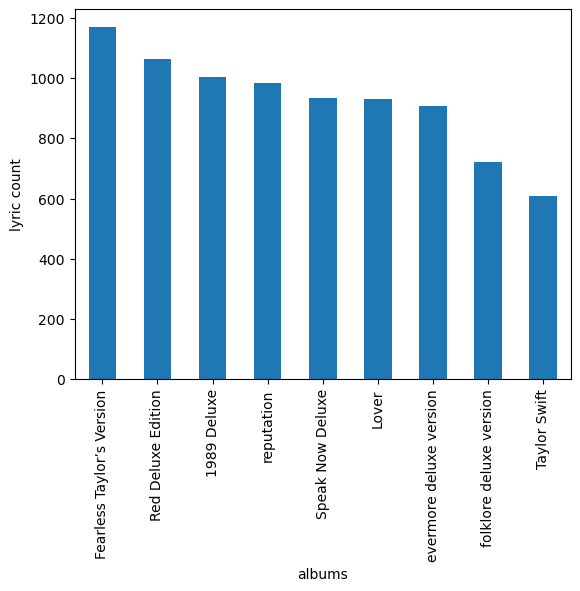

In [40]:
# Visualizing the data of 'count_per_album' as a bar plot using your function
plot_lyric_count(count_per_album)

ii. Is the data balanced enough for album classification?

__Student Answer:__ No it is not balanced enough. Some albums almost have 2 times more lyrics than others.

### d)
In the following, we want to remove duplicate lyrics, as a song may contain a lyric more than once. Removing duplicates improves the interpretability of the further analysis and reduces an overfitting of the classification task on the duplicated lyrics. 

i. Therefore, as a first step, we remove all duplicate lyrics and keep only a single instance per duplicate lyric on each album. The obtained dataset has to be named `swift_df_proc`.

In [41]:
# Dropping all duplicates of a lyric on an album
# YOUR CODE HERE
swift_df_proc = swift_df.copy()
swift_df_proc = swift_df_proc.drop_duplicates(subset=['album', 'lyric'])
a = count_lyrics_per_album(swift_df_proc)
display(a)

album
Fearless Taylor’s Version    825
Speak Now Deluxe             681
Red Deluxe Edition           665
Lover                        632
evermore deluxe version      632
reputation                   598
1989 Deluxe                  580
folklore deluxe version      544
Taylor Swift                 402
Name: count, dtype: int64

ii. Do lyrics occur in several albums? If this is the case, remove them entirely as such a lyric is not suitable for our further questions. If this is not the case, give the code that shows so. Remember also to give a clear answer below. 

In [42]:
# YOUR CODE HERE
duplicate_lyric = swift_df_proc[swift_df_proc.duplicated(subset='lyric', keep=False)]
display(duplicate_lyric)

album  \
216                Taylor Swift   
312                Taylor Swift   
491                Taylor Swift   
614   Fearless Taylor’s Version   
631   Fearless Taylor’s Version   
743   Fearless Taylor’s Version   
796   Fearless Taylor’s Version   
871   Fearless Taylor’s Version   
1685  Fearless Taylor’s Version   
1710  Fearless Taylor’s Version   
1823           Speak Now Deluxe   
1972           Speak Now Deluxe   
2236           Speak Now Deluxe   
2936         Red Deluxe Edition   
3114         Red Deluxe Edition   
3140         Red Deluxe Edition   
3294         Red Deluxe Edition   
3588         Red Deluxe Edition   
3829                1989 Deluxe   
4379                1989 Deluxe   
4381                1989 Deluxe   
4414                1989 Deluxe   
4540                1989 Deluxe   
4554                1989 Deluxe   
4831                 reputation   
5828                      Lover   
6134                      Lover   
6610                      Lover   
6716    folklore deluxe version   
7383    folklore deluxe version   
7800    evermore deluxe version   
7806    evermore deluxe version   
8008    evermore deluxe version   

                                                  lyric  
216                                            Oh, yeah  
312                                      Oh, oh, oh, oh  
491                                            With you  
614                                            Oh, yeah  
631                                              Oh, oh  
743                                          Oh, oh, oh  
796                                            Oh-oh-oh  
871                          In the middle of the night  
1685                                         And I said  
1710                                         Ah, ah, ah  
1823                                         Yeah, yeah  
1972                                           Ooh, ooh  
2236  Nardo Wick 'Who Want Smoke??' Live Performance...  
2936                                         Oh, oh, oh  
3114                                           Oh-oh-oh  
3140                                         And I said  
3294  Nardo Wick 'Who Want Smoke??' Live Performance...  
3588                                       Oh-oh, oh-oh  
3829                                                Ayy  
4379                                         Oh, oh, oh  
4381                                       Oh-oh, oh-oh  
4414                                         Yeah, yeah  
4540                                     Oh, oh, oh, oh  
4554                                             Oh, oh  
4831                         In the middle of the night  
5828                                           With you  
6134                                                Ayy  
6610                                                Ooh  
6716                                                Ooh  
7383                                         Ah, ah, ah  
7800                                           Ooh, ooh  
7806                                                Ooh  
8008                                         Yeah, yeah

In [43]:
#remove duplicate lyrics in all
swift_df_proc = swift_df_proc.drop_duplicates(subset=['lyric'], keep=False)
duplicate_lyric = swift_df_proc[swift_df_proc.duplicated(subset='lyric', keep=False)]
display(duplicate_lyric)
a = count_lyrics_per_album(swift_df_proc)
display(a)

Empty DataFrame
Columns: [album, lyric]
Index: []

album
Fearless Taylor’s Version    818
Speak Now Deluxe             678
Red Deluxe Edition           660
Lover                        629
evermore deluxe version      629
reputation                   597
1989 Deluxe                  574
folklore deluxe version      542
Taylor Swift                 399
Name: count, dtype: int64

__Student Answer:__ Yes, above lyrics occur in several albums.

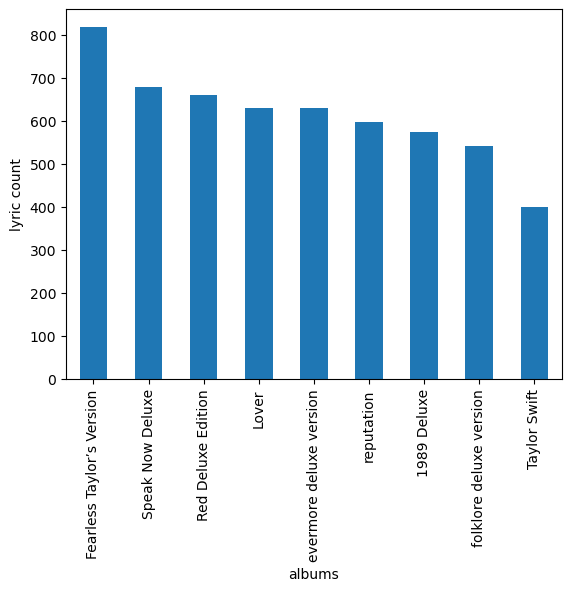

album
Fearless Taylor’s Version    818
Speak Now Deluxe             678
Red Deluxe Edition           660
Lover                        629
evermore deluxe version      629
reputation                   597
1989 Deluxe                  574
folklore deluxe version      542
Taylor Swift                 399
Name: count, dtype: int64

In [44]:
plot_lyric_count(count_lyrics_per_album(swift_df_proc))
count_lyrics_per_album(swift_df_proc)

### e)
The following tasks are more related to the preprocessing that has to be applied for the Text Mining context. First of all, we have to create a corpus. The obtained corpus should be named `corpus`. Make sure that each document in the corpus corresponds to exactly one lyric in `swift_df_proc`. 

In [45]:
# Creating the corpus
# YOUR CODE HERE
swift_df_corpus = swift_df_proc.copy()
corpus = swift_df_corpus['lyric'].tolist()
display((corpus[:5]))


['He said the way my blue eyes shined',
 'Put those Georgia stars to shame that night',
 'I said, "That\'s a lie"',
 'Just a boy in a Chevy truck',
 "That had a tendency of gettin' stuck"]

### f)
Use the skeleton of the function `preprocessor_func` below to create a function that applies tokenization, stopword removal and lemmatization to an input string. The remaining tokens (after stopword removal and lemmatization) should be joined using a whitespace (' ').

_Note: To keep the complexity low, we do not expect you to use POS tagging before lemmatizing. You can apply lemmatization only for the nouns. This is covered by using a lemmatizer without further arguments._

In [46]:
def preprocessor_func(text: str) -> str:
    """
    Preprocesses a string using tokenization, stopword removal and lemmatization.
    :param text: A string to be preprocessed.
    :return: A joined string resulting from tokenization, stopword removal and lemmatization of an input string.
    """
    # YOUR CODE HERE
    # Tokenize
    tokenized = reg_tokenizer.tokenize(text)
    
    # Filter stop words
    filtered = [word.lower() for word in tokenized if word.lower() not in stopword_list]

    # Lemmatize tokens
    lemmatized = [wordnet_lemmatizer.lemmatize(word) for word in filtered]

    # Join tokens to sentence
    return ' '.join(lemmatized)

### g)
Now, create a preprocessed corpus `corpus_proc` by applying the preprocessing function to your corpus. For some tasks, we have to use the preprocessed corpus, and for some, the original corpus. This is indicated for each task.

In [47]:
# Corpus preprocessing
# YOUR CODE HERE
corpus_proc = [preprocessor_func(lyric) for lyric in corpus]
print(corpus_proc)

['said way blue eye shined', 'put georgia star shame night', 'said lie', 'boy chevy truck', 'tendency gettin stuck', 'back road night', 'right beside summer long', 'time woke find summer gone', 'think tim mcgraw', 'hope think favorite song', 'one danced night long', 'moon like spotlight lake', 'think happiness', 'hope think little black dress', 'think head chest', 'old faded blue jean', 'think tim mcgraw', 'hope think', 'september saw month tear', 'thankin god', 'see like', 'box beneath bed', 'letter never read', 'three summer back', 'hard find little bittersweet', 'lookin back nice believe', 'back first time since', 'standin street', 'letter left doorstep', 'first thing read', 'think tim mcgraw', 'someday turn radio', 'hope take back place', 'oh think', 'mmmm', 'state obvious get perfect fantasy', 'realize love could ever love', 'go tell friend obsessive crazy', 'fine tell mine gay', 'way', 'hate stupid old pickup truck', 'never let drive', 'redneck heartbreak', 'really bad lying', 'w

### h)
In this task, we create all preprocessed data for all remaining tasks within the Text Mining question exercise.
For the later application of the set of words, we need to split the corpus.
First, we need to split our input data into a train and test set according to the Pareto rule (80% training set size and 20% test set size).
Therefore, split the dataframe `swift_df_proc` into a training and test set using the variable identifiers `df_train`, `df_test`, `y_train`, and `y_test`.
Further, make sure that distribution based on the "album" value is preserved.

In [535]:
# YOUR CODE HERE
x = swift_df_proc.drop(columns=['album'])
y = swift_df_proc['album']
df_train, df_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

### i)
Lastly, we create two further corpora, `corpus_train` and `corpus_test`, using the split data and the identical approach that is used before.

In [536]:
# YOUR CODE HERE
corpus_train = [preprocessor_func(lyric) for lyric in df_train['lyric']]
corpus_test = [preprocessor_func(lyric) for lyric in df_test['lyric']]

## Set of Words (6.5 Pts)

In this subtask, we use the set of words technique to distinguish and recognize different lyrics based on which album they belong to. Set of words encodes the documents by indicating for each word in our vocabulary whether the word occurs in the sentence or not.

### j)
Create a set of words encoding for the whole corpus. Use the previously defined preprocessor function `preprocessor_func` for our corpus `corpus`. 

In [537]:
# Creating a set of words using the propressor function and the corpus
# YOUR CODE HERE
vectorizer = CountVectorizer(binary=True, preprocessor=preprocessor_func)
set_of_words_encoding = vectorizer.fit(corpus)

### k)
In the following, we want to have a first look at how the set of words classification works. Therefore, we apply the set of words to a line in the `swift_df`. Use the `apply_sow_to_line_by_index` function that is given an index of a lyric and that returns the original line, its preprocessed form, and its encoding resulting from the set of words implementation.
Comment below on what information the set of words representation contains.

In [538]:
def apply_sow_to_lyric_by_index(index: int) -> (str, str, _):
    """ 
    Applies set of words to a lyric in the swift_df.
    :param index: The index of the chosen lyric entry.
    :return: The function returns the chosen lyric, it preprocessed form and the set of words representation. 
    """
    # YOUR CODE HERE
    original_lyric = swift_df_proc.iloc[index]['lyric']
    preprocessed_lyric = preprocessor_func(original_lyric)
    # set of words encoding
    # set_of_words_encoding = vectorizer.transform([preprocessed_lyric])
    set_of_words_encoding = vectorizer.transform([original_lyric]).toarray()

    return original_lyric, preprocessed_lyric, set_of_words_encoding



In [539]:
# YOUR CODE HERE
# example index=1
index = 1
line, line_p, line_sow = apply_sow_to_lyric_by_index(index)
print('Original line:     ', line)
print('Preprocessed line: ', line_p)
print('SoW encoding:\n', line_sow)

Original line:      Put those Georgia stars to shame that night
Preprocessed line:  put georgia star shame night
SoW encoding:
 [[0 0 0 ... 0 0 0]]


In [540]:
line, line_p, line_sow = apply_sow_to_lyric_by_index(index)
print('Original line:     ', line)
print('Preprocessed line: ', line_p)
print('SoW encoding:\n', line_sow)

Original line:      Put those Georgia stars to shame that night
Preprocessed line:  put georgia star shame night
SoW encoding:
 [[0 0 0 ... 0 0 0]]


__Student Answer:__ The set of words representation contains information about the exsistence of each word in the vocabulary of a sepecific lyric. The value “1” means the word presents in the lyric and "0" means it is absent.

### l)
In this subtask, we use a **S**tochastic **G**radient **D**escent classifier to predict the album given a lyric for the corpus. Therefore, the steps to follow are briefly described below:
 1. First, we create a set of words encoding for the whole corpus. As we want to evaluate our results later using the test set, restrict yourself in the training to only use the training set `corpus_train`. 
 2. Train the classifier on the training set with 'album' as the target feature and 'log_loss' as the loss function.
 3. Predict the album for each line in the training and test set `corpus_test`.
 4. Calculate and show the accuracy for both the training and test set and store them in the variables `accuracy_train` and `accuracy_test`.

In [541]:
# Creating the set of words encoding
# YOUR CODE HERE
vectorizer_train = CountVectorizer(binary=True)
set_of_words_encoding_train = vectorizer_train.fit_transform(corpus_train)

In [542]:
# Train the classifier
# YOUR CODE HERE
classifier = SGDClassifier(loss="log_loss")
classifier.fit(set_of_words_encoding_train, y_train)

SGDClassifier(loss='log_loss')

In [543]:
# Predict the album
# YOUR CODE HERE
set_of_words_encoding_test = vectorizer_train.transform(corpus_test)
predictions_train = classifier.predict(set_of_words_encoding_train)
predictions_test = classifier.predict(set_of_words_encoding_test)

In [544]:
# Compute and show accuracy for training and test set
# YOUR CODE HERE
accuracy_train = accuracy_score(y_train, predictions_train)
accuracy_test = accuracy_score(y_test, predictions_test)

print("Training Set:", accuracy_train)
print("Test Set:", accuracy_test)

Training Set: 0.7597285067873303
Test Set: 0.32730560578661844


### m)
Given the accuracy values that you calculated in the last subtask, argue about the classifier's accuracy compared to a most frequent guessing classifier (i.e., a classifier that always chooses to predict the most frequent album). Use the distribution of lyrics over the albums calculated in task **d)** to support your argument. 

__Student Answer:__ From the task d, we know that the accuracy of the most frequent guessing classifier is 818/5526 = 0.148028. The accuracy of our SGD Classifier of the test set is 0.327306, which is higher than 0.148028, but still not ideal. This may cause by the low amount of overall data amount, the low differences of lyrics between albums, and the bad distribution of lyrics over the albums.

### n)
Next, we want to make our results more visual. Therefore, implement the `pred_album_by_index` method that takes a lyric's index from the `swift_df` dataframe as input, and based on that, returns the corresponding lyric, its actual album and its predicted album using the SGD classifier from **l)**.

In [545]:
def pred_album_by_index(index: int) -> (str, str, str):
    """ 
    Predicts a lyric's album based on the .
    :param index: The index of the chosen lyric entry.
    :return: The function returns the chosen lyric, it preprocessed form and the set of words representation. 
    """
    # YOUR CODE HERE
    original_lyric = swift_df_proc.iloc[index]['lyric']
    actual_album = swift_df_proc.iloc[index]['album']
    
    preprocessed_lyric = preprocessor_func(original_lyric)

    set_of_words_encoding = vectorizer_train.transform([preprocessed_lyric])

    predicted_album = classifier.predict(set_of_words_encoding)[0]

    return original_lyric, actual_album, predicted_album

In [546]:
index = 1455 # Please change the index and do not use -1

In [547]:
lyric, album_actual, album_pred = pred_album_by_index(index)

print("Lyric:          ", lyric)
print("Actual album:   ", album_actual)
print("Predicted album:", album_pred)

Lyric:           And all you're ever gonna be is mean, yeah
Actual album:    Speak Now Deluxe
Predicted album: Speak Now Deluxe


## Doc2Vec (4.5 pts)

In this subtask, we encode lyrics using Doc2Vec. Given the embedding, we reduce its dimensionality using **P**rincipal **C**omponent **A**nalysis while preserving the maximum amount of information so that we can visualize and cluster the embeddings in a scatter plot. Lastly, we have a manual look at the clusters to evaluate the information gain of the Doc2Vec approach.

### o) 
Initialize and train a Doc2Vec model based on the documents in the preprocessed corpus `corpus_p`. Set `epochs=100` for the training of the model. Set the vector dimension to 20 and min_count to 3.

In [549]:
# Calculating the number of cores available
cores = multiprocessing.cpu_count()

# YOUR CODE HERE
# import matplotlib as mpl
import matplotlib.pyplot as plt

corpus_p = []
for doc in corpus:
    doc_p = preprocessor_func(doc)
    corpus_p.append(doc_p)


docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus_p)]
doc2vec = Doc2Vec(vector_size = 20, min_count = 3, workers=cores, epochs = 100)
doc2vec.build_vocab(docs)
doc2vec.train(docs, total_examples=doc2vec.corpus_count, epochs = 100)

### p)
Create an embedding for each lyric in `swift_df_proc` and add all embeddings inferred to the `lyric_embeddings` list. This is a pretask for the next step that we take. 

In [550]:
lyric_embeddings = []

# YOUR CODE HERE

for index, row in swift_df_proc.iterrows():

    preprocessed_lyric = preprocessor_func(row['lyric'])

    embedding = doc2vec.infer_vector(reg_tokenizer.tokenize(preprocessed_lyric))
    
    lyric_embeddings.append(embedding)


print(lyric_embeddings)

[array([ 0.00213954, -0.0211125 , -0.00709246, -0.01940036, -0.00677029,
       -0.0046722 , -0.01297494,  0.02393072, -0.02157944,  0.00493251,
       -0.0233249 , -0.01202565,  0.01647252,  0.01924292,  0.00386992,
        0.02349286,  0.00374041,  0.0068798 , -0.02042518,  0.01659902],
      dtype=float32), array([ 0.02144403,  0.00875612, -0.02488829,  0.00715996, -0.00143712,
        0.01952769,  0.0210964 , -0.0117499 , -0.01099161,  0.0218812 ,
        0.00488961,  0.01444915, -0.0108159 ,  0.00067604, -0.0042784 ,
       -0.00810231,  0.0201612 ,  0.02153614, -0.00018765,  0.01840138],
      dtype=float32), array([ 0.0234689 , -0.02304613,  0.02396284,  0.01930404, -0.00064912,
        0.00933838,  0.01047587,  0.00789436, -0.0047966 ,  0.00749108,
        0.01349086,  0.01376856, -0.01683356, -0.00408188, -0.00784042,
        0.01454243, -0.00134675, -0.00179071, -0.01249914, -0.00820131],
      dtype=float32), array([-0.00196289,  0.01555315,  0.01616449, -0.0220822 , -0.0137

### q)
Store the data contained in `lyric_embeddings` in a dataframe `embeddings_df`.
Apply DBSCAN with euclidean distance to the `embeddings_df`dataframe with `eps = 0.3` and `min_samples = 2` and create a scatterplot with seaborn that shows the clusters of the inferred vectors. To be able to visualize the data in a two-dimensional vector space, apply a **p**rinciple **c**omponent **a**nalysis that is able to reduce the dimensionality of input data. (You can learn more about the PCA in its [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)). The code for the PCA is provided.

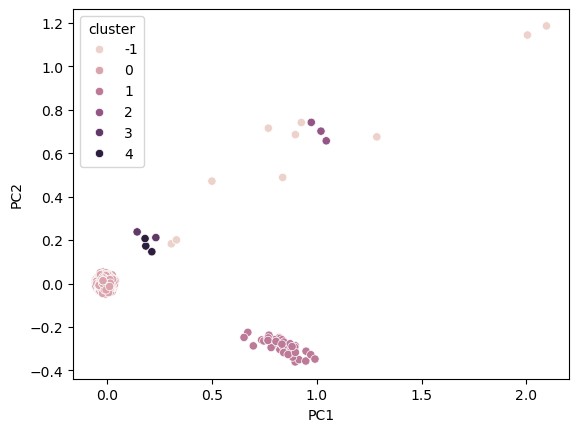

In [551]:
# YOUR CODE HERE
embeddings_df = pd.DataFrame(lyric_embeddings)
#display(embeddings_df)

dbscan = DBSCAN(eps = 0.3, min_samples = 2)
#embeddings_df['cluster'] = dbscan.fit_predict(embeddings_df)

# Applying PCA to the embedding reducing the dimensionality to two
pca = PCA(n_components = 2)
pca_embeddings = pd.DataFrame(pca.fit_transform(embeddings_df))

# YOUR CODE HERE

embeddings_df['cluster'] = dbscan.fit_predict(embeddings_df)
sns.scatterplot(x = pca_embeddings.iloc[:, 0], y = pca_embeddings.iloc[:, 1], hue = embeddings_df['cluster'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


### r)
Show lyrics from the original `swift_df` dataframe contained in two distinct clusters using the two cells below. Answer separately, whether you consider the lyrics in each cluster to be similar or dissimilar.

_Note: You do not have to find exactly two clusters. Having at least two clusters, you should show the lyrics from two distinct clusters._ 

In [556]:
# Lyrics contained in one cluster
# YOUR CODE HERE
cluster_1_lyrics = embeddings_df[embeddings_df['cluster'] == 0]
#cluster_1_lyrics = cluster_1_lyrics.reset_index(drop = True)
cluster_1_lyrics = cluster_1_lyrics.index.tolist()

swift_df_proc = swift_df_proc.reset_index(drop=True)



combined_df = swift_df_proc[swift_df_proc.index.isin(cluster_1_lyrics)]
swift_df_cluster_1 = swift_df[swift_df['lyric'].isin(combined_df['lyric'])]
display(swift_df_cluster_1)

album  \
0                  Taylor Swift   
1                  Taylor Swift   
2                  Taylor Swift   
3                  Taylor Swift   
4                  Taylor Swift   
5                  Taylor Swift   
6                  Taylor Swift   
7                  Taylor Swift   
8                  Taylor Swift   
9                  Taylor Swift   
10                 Taylor Swift   
11                 Taylor Swift   
12                 Taylor Swift   
13                 Taylor Swift   
14                 Taylor Swift   
15                 Taylor Swift   
16                 Taylor Swift   
17                 Taylor Swift   
18                 Taylor Swift   
19                 Taylor Swift   
20                 Taylor Swift   
21                 Taylor Swift   
22                 Taylor Swift   
23                 Taylor Swift   
24                 Taylor Swift   
25                 Taylor Swift   
26                 Taylor Swift   
27                 Taylor Swift   
28                 Taylor Swift   
29                 Taylor Swift   
30                 Taylor Swift   
31                 Taylor Swift   
32                 Taylor Swift   
33                 Taylor Swift   
34                 Taylor Swift   
35                 Taylor Swift   
36                 Taylor Swift   
37                 Taylor Swift   
38                 Taylor Swift   
39                 Taylor Swift   
40                 Taylor Swift   
41                 Taylor Swift   
42                 Taylor Swift   
43                 Taylor Swift   
44                 Taylor Swift   
45                 Taylor Swift   
46                 Taylor Swift   
47                 Taylor Swift   
48                 Taylor Swift   
49                 Taylor Swift   
50                 Taylor Swift   
51                 Taylor Swift   
52                 Taylor Swift   
53                 Taylor Swift   
54                 Taylor Swift   
55                 Taylor Swift   
56                 Taylor Swift   
57                 Taylor Swift   
58                 Taylor Swift   
59                 Taylor Swift   
60                 Taylor Swift   
61                 Taylor Swift   
62                 Taylor Swift   
63                 Taylor Swift   
64                 Taylor Swift   
65                 Taylor Swift   
66                 Taylor Swift   
67                 Taylor Swift   
68                 Taylor Swift   
69                 Taylor Swift   
70                 Taylor Swift   
71                 Taylor Swift   
72                 Taylor Swift   
73                 Taylor Swift   
74                 Taylor Swift   
75                 Taylor Swift   
76                 Taylor Swift   
77                 Taylor Swift   
78                 Taylor Swift   
79                 Taylor Swift   
80                 Taylor Swift   
81                 Taylor Swift   
82                 Taylor Swift   
83                 Taylor Swift   
84                 Taylor Swift   
85                 Taylor Swift   
86                 Taylor Swift   
87                 Taylor Swift   
88                 Taylor Swift   
89                 Taylor Swift   
90                 Taylor Swift   
91                 Taylor Swift   
92                 Taylor Swift   
93                 Taylor Swift   
94                 Taylor Swift   
95                 Taylor Swift   
96                 Taylor Swift   
97                 Taylor Swift   
98                 Taylor Swift   
99                 Taylor Swift   
100                Taylor Swift   
101                Taylor Swift   
102                Taylor Swift   
103                Taylor Swift   
104                Taylor Swift   
105                Taylor Swift   
106                Taylor Swift   
107                Taylor Swift   
108                Taylor Swift   
109                Taylor Swift   
110                Taylor Swift   
111                Taylor Swift   
112                Taylor Swift   
113                Taylor Swift   
1

In [557]:
# Lyrics contained in one cluster
# YOUR CODE HERE
cluster_2_lyrics = embeddings_df[embeddings_df['cluster'] == 1]
#cluster_2_lyrics = cluster_2_lyrics.reset_index(drop = True)
cluster_2_lyrics = cluster_2_lyrics.index.tolist()

swift_df_proc = swift_df_proc.reset_index(drop=True)



combined_df = swift_df_proc[swift_df_proc.index.isin(cluster_2_lyrics)]
swift_df_cluster_2 = swift_df[swift_df['lyric'].isin(combined_df['lyric'])]
display(swift_df_cluster_2)

album  \
364                Taylor Swift   
377                Taylor Swift   
889   Fearless Taylor’s Version   
906   Fearless Taylor’s Version   
1161  Fearless Taylor’s Version   
1163  Fearless Taylor’s Version   
1174  Fearless Taylor’s Version   
1176  Fearless Taylor’s Version   
1185  Fearless Taylor’s Version   
2107           Speak Now Deluxe   
2123           Speak Now Deluxe   
2128           Speak Now Deluxe   
2141           Speak Now Deluxe   
2149           Speak Now Deluxe   
2156           Speak Now Deluxe   
2162           Speak Now Deluxe   
2381           Speak Now Deluxe   
2449           Speak Now Deluxe   
2527           Speak Now Deluxe   
2550           Speak Now Deluxe   
3291         Red Deluxe Edition   
3915                1989 Deluxe   
3958                1989 Deluxe   
4034                1989 Deluxe   
4213                1989 Deluxe   
4504                1989 Deluxe   
4514                1989 Deluxe   
4520                1989 Deluxe   
4587                1989 Deluxe   
4613                1989 Deluxe   
4725                1989 Deluxe   
4746                1989 Deluxe   
4769                1989 Deluxe   
4773                1989 Deluxe   
5205                 reputation   
5226                 reputation   
5278                 reputation   
5357                 reputation   
5358                 reputation   
5380                 reputation   
5476                 reputation   
5489                 reputation   
5551                 reputation   
6198                      Lover   
6412                      Lover   
6418                      Lover   
6441                      Lover   
6503                      Lover   
6507                      Lover   
6523                      Lover   
6539                      Lover   
6845    folklore deluxe version   
7019    folklore deluxe version   
7022    folklore deluxe version   
7029    folklore deluxe version   
7032    folklore deluxe version   
7041    folklore deluxe version   
7044    folklore deluxe version   
7047    folklore deluxe version   
7651    evermore deluxe version   
7899    evermore deluxe version   
8018    evermore deluxe version   

                                                  lyric  
364    And our daddies used to joke about the two of us  
377    And our daddies used to joke about the two of us  
889   'Cause none of us thought it was gonna end tha...  
906   And nothin' we say is gonna save us from the f...  
1161  These walls that they put up to hold us back w...  
1163                              For us to finally win  
1174  These walls that they put up to hold us back w...  
1176                              For us to finally win  
1185  When the walls that they put up to hold us bac...  
2107  I used to think one day, we'd tell the story o...  
2123  And the story of us looks a lot like a tragedy...  
2128  I'm starting to think one day, I'll tell the s...  
2141  And the story of us looks a lot like a tragedy...  
2149           But the story of us might be ending soon  
2156  And the story of us looks a lot like a tragedy...  
2162  And the story of us looks a lot like a tragedy...  
2381                  Every one of us has messed up too  
2449                                For just us to know  
2527                     When they gave us our trophies  
2550                        And force us into a goodbye  
3291  Hang up, give up, and for the life of us we ca...  
3915            Watch us go 'round and 'round each time  
3958                          You took a Polaroid of us  
4034                    All I know is that you drove us  
4213              But it made us turn right back around  
4504  And they'll be chasing their tails trying to t...  
4514  And they'll be chasing their tails trying to t...  
4520  And they'll be chasing their tails trying to t...  
4587        Didn't they tell us don't rush into things?  
4613        Didn't they tell us don't rush into things?  
4725            But ev

__Student Answer:__ For the lyrics belonging to the cluster 0, I think the lyrics have some kind of similarity. The lyrics are mostly long sentences with clauses.
For the lyrics belonging to the cluster 1, I think the lyrics also have some similarity. The lyrics often start with “and” and “but”.


## An N-Gram Based Language Model (4 Pts)

In this subtask, we use the `swift_df` data to create an n-gram based language model to generate new lyrics. Therefore, we play around with different values for n.

### s)
Write the `lyric_preprocessor` method that takes a lyric as input and that tokenizes it and makes each word lowercase.

In [48]:
def lyric_preprocessor(lyric: str) -> [str]:
    """
    Tokenizes a lyric and makes the tokens lowercase.
    :param lyric: A string containing an input lyric.
    :return: A list containing lowercase tokens of the input lyric.
    """
    # YOUR CODE HERE
    tokens = reg_tokenizer.tokenize(lyric.lower())
    #tokens = lyric.lower().split()
    return tokens


### t)
Apply the lyric_preprocessor to all lyrics in the `swift_df` and store the data in a `lyric_corpus` variable.

In [49]:
# YOUR CODE HERE
lyric_corpus = swift_df['lyric'].apply(lyric_preprocessor)
print(lyric_corpus.head())

0         [he, said, the, way, my, blue, eyes, shined]
1    [put, those, georgia, stars, to, shame, that, ...
2                           [i, said, that, s, a, lie]
3                  [just, a, boy, in, a, chevy, truck]
4          [that, had, a, tendency, of, gettin, stuck]
Name: lyric, dtype: object


Next, train two n-grams with $n \in \{2,5\}$ on the lyric_corpus.

In [50]:
# YOUR CODE HERE
padded_tuples, padded_corpus = padded_everygram_pipeline(2, lyric_corpus)
ngram_model2 = MLE(2)
ngram_model2.fit(padded_tuples, padded_corpus)

padded_tuples, padded_corpus = padded_everygram_pipeline(5, lyric_corpus)
ngram_model5 = MLE(5)
ngram_model5.fit(padded_tuples, padded_corpus)



### u)
i. Write the `generate_lyrics` method that takes an n-gram model and an integer for the number of lyrics to be generated as input and that returns a list of new lyrics that were generated using the given n-gram model.

_Reminder / Hints: A lyric generated by an n-gram starts with n-1 times the start token "\<s>" and ends with n-1 times the end token "\</s>". Further, the n value of an n-gram can be accessed using the `n-gram.order` variable of an `n-gram`. Additionally keep in mind that you can condition the generation of your n-gram on some preceding text._

In [51]:
def generate_lyrics(ngram_model, numb_of_new_lyric: int) -> [str]:
    """
    Uses an n-gram model to generate several new lyrics.
    :param n_gram_model: An n-gram model. 
    :param numb_of_new_lyrics: The number of lyrics to be created.
    :return: As many generated lyrics as defined by the numb_of_new_lyrics.
    """
    # YOUR CODE HERE
    start_token = "<s>"
    end_token = "</s>"
    generated_lyric = []
    num_lyric = numb_of_new_lyric

    for _ in range(num_lyric):
        context = [start_token] * (ngram_model.order - 1)
        lyric = []
        while True:
            next_word = ngram_model.generate(text_seed=context[-(ngram_model.order - 1):])
            if next_word == end_token:
                break
            lyric.append(next_word)
            context.append(next_word)
            
        generated_lyric.append(' '.join(lyric))

    return generated_lyric







ii. Generate with the first and the second model ten lyrics each. Name one difference that you can find between the lyrics generated with 2-gram model and with the 5-gram model.

In [52]:
# Generate and show ten lyrics with the first model
# YOUR CODE HERE
generate_lyrics_2 = generate_lyrics(ngram_model2, 10)
print("Generated Lyrics with n=2:")
for lyric in generate_lyrics_2:
    display(lyric)

Generated Lyrics with n=2:


'haven t wanna be the rabbit hole in your truck tires'

'fighting with you re the lights up windshield glass'

'in my last time ruining everything is wishful thinking'

'take me when it'

'you around'

'so many signs'

'you are too'

'this town yeah'

'ooh look at me do or a simple'

'and it s best day until i meet'

In [60]:
# Generate and show ten lyrics with the first model
# YOUR CODE HERE
generate_lyric_5 = generate_lyrics(ngram_model5, 10)
print("Generated Lyrics with n=5:")
for lyric in generate_lyric_5:
    display(lyric)

Generated Lyrics with n=5:


'miracle'

'this ain t the best view'

'who s counting one two three'

'betty i m here on your doorstep'

'i got no one to believe in'

'you just need to take several seats and then try to restore the peace'

'when i passed your house'

'all the kingdom lights shined just for me and you'

'i say i hate you we break up you call me i love you'

'you need to hear me out'

__Student Answer:__ The 5-gram can produce lyrics with more complex structures. The lyrics are more readable, understandable, and more logical than the lyrics produced by 2-gram.